<a href="https://colab.research.google.com/github/peterbmob/DHMVADoE/blob/main/Excercises/fractional_design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Fractional 2$^k$  Factorial Designs
**Motivation**

The prior section showed an example of what an experimental design might like look like for 6 variables. However, this resulted in a  2$^6$=64
  experiment design campaign. This is potentially a major issue - if each experiment take 6 hours, and have to be staggered over working hours on weekdays, you're looking at almost 90 days turnaround time, assuming each experiment is carried out flawlessly. This is simply not a realistic view of experimentation.

In addition, we saw that a three-coefficient model captured nearly as much detail as a 64-coefficient model. By reducing the number of input variables we looked at, we turned certain experiments into replicates (because the only thing changed bewteen them were insignificant variables or variable combinations).

But we can halve or quarter our effort, and substantially improve our effectiveness in the lab, by carefully selecting experiments at each stage of the experiment to reveal a maximum amount of information, and avoiding as much as possible these kinds of duplicate experiments, through a fractional factorial design.

In [ ]:
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
import pylab

import scipy.stats as stats
import statsmodels.api as sm

After re-casting the problem in a general form, we begin with the experimental design matrix. If we were to construct the full factorial for our  2$^6$ factorial example, we would again have 64 rows in our experimental design matrix dataframe, corresponding to 64 experiments to run.

In [ ]:
column_labs = ['x%d'%(i+1) for i in range(6)]
encoded_inputs = list( itertools.product([-1,1],[-1,1],[-1,1],[-1,1],[-1,1],[-1,1]) )

# Create the experiment design table (same as the book):
doe=pd.DataFrame(encoded_inputs)
doe=doe[doe.columns[::-1]]
doe.columns=['x%d'%(i+1) for i in range(6)]

print(len(doe))
doe

64


,x1,x2,x3,x4,x5,x6
0,-1,-1,-1,-1,-1,-1
1,1,-1,-1,-1,-1,-1
2,-1,1,-1,-1,-1,-1
3,1,1,-1,-1,-1,-1
4,-1,-1,1,-1,-1,-1
...,...,...,...,...,...,...
59,1,1,-1,1,1,1
60,-1,-1,1,1,1,1
61,1,-1,1,1,1,1
62,-1,1,1,1,1,1


In [ ]:
labels = {}
labels[1] = ['x1','x2','x3','x4','x5','x6']
for i in [2,3,4,5,6]:
    labels[i] = list(itertools.combinations(labels[1], i))

obs_list = ['y1','y2','y3']

for k in labels.keys():
    print(str(k) + " : " + str(labels[k]))



1 : ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
2 : [('x1', 'x2'), ('x1', 'x3'), ('x1', 'x4'), ('x1', 'x5'), ('x1', 'x6'), ('x2', 'x3'), ('x2', 'x4'), ('x2', 'x5'), ('x2', 'x6'), ('x3', 'x4'), ('x3', 'x5'), ('x3', 'x6'), ('x4', 'x5'), ('x4', 'x6'), ('x5', 'x6')]
3 : [('x1', 'x2', 'x3'), ('x1', 'x2', 'x4'), ('x1', 'x2', 'x5'), ('x1', 'x2', 'x6'), ('x1', 'x3', 'x4'), ('x1', 'x3', 'x5'), ('x1', 'x3', 'x6'), ('x1', 'x4', 'x5'), ('x1', 'x4', 'x6'), ('x1', 'x5', 'x6'), ('x2', 'x3', 'x4'), ('x2', 'x3', 'x5'), ('x2', 'x3', 'x6'), ('x2', 'x4', 'x5'), ('x2', 'x4', 'x6'), ('x2', 'x5', 'x6'), ('x3', 'x4', 'x5'), ('x3', 'x4', 'x6'), ('x3', 'x5', 'x6'), ('x4', 'x5', 'x6')]
4 : [('x1', 'x2', 'x3', 'x4'), ('x1', 'x2', 'x3', 'x5'), ('x1', 'x2', 'x3', 'x6'), ('x1', 'x2', 'x4', 'x5'), ('x1', 'x2', 'x4', 'x6'), ('x1', 'x2', 'x5', 'x6'), ('x1', 'x3', 'x4', 'x5'), ('x1', 'x3', 'x4', 'x6'), ('x1', 'x3', 'x5', 'x6'), ('x1', 'x4', 'x5', 'x6'), ('x2', 'x3', 'x4', 'x5'), ('x2', 'x3', 'x4', 'x6'), ('x2', 'x3', 'x5', 'x6

In [ ]:
# Add columns for all possible interaction effects to the doe DataFrame
for k in labels.keys():
    if k == 1:
        # Main effects are already in the DataFrame
        continue
    for interaction_factors in labels[k]:
        # Create the column name for the interaction
        interaction_col_name = '*'.join(interaction_factors)
        # Calculate the interaction effect by multiplying the columns
        doe[interaction_col_name] = doe[list(interaction_factors)].prod(axis=1)

print("DataFrame with all interaction effects added:")
display(doe.head())
print("\nShape of the DataFrame:", doe.shape)

DataFrame with all interaction effects added:


,x1,x2,x3,x4,x5,x6,x1*x2,x1*x3,x1*x4,x1*x5,...,x2*x3*x5*x6,x2*x4*x5*x6,x3*x4*x5*x6,x1*x2*x3*x4*x5,x1*x2*x3*x4*x6,x1*x2*x3*x5*x6,x1*x2*x4*x5*x6,x1*x3*x4*x5*x6,x2*x3*x4*x5*x6,x1*x2*x3*x4*x5*x6
0,-1,-1,-1,-1,-1,-1,1,1,1,1,...,1,1,1,-1,-1,-1,-1,-1,-1,1
1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,-1,-1
2,-1,1,-1,-1,-1,-1,-1,1,1,1,...,-1,-1,1,1,1,1,1,-1,1,-1
3,1,1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,1,1,1
4,-1,-1,1,-1,-1,-1,1,-1,1,1,...,-1,1,-1,1,1,1,-1,1,1,-1



Shape of the DataFrame: (64, 63)


## Design Matrix
Let's talk a bit more about the design matrix. Each column of the design matrix corresponds to a unique coded input variable value (−1,+1). But each experiment also has a corresponding coded value for each two-variable interaction  x$_i$,x$_j$, and for each three-variable interaction  x$_k$,x$_m$,x$_n$, and so on.

These interactions are simply the product of each coded variable value. For example, if

\begin{equation}
x_1=−1 \\
\end{equation}

\begin{equation}
x_2=+1 \\
\end{equation}

\begin{equation}
x_3=+1
\end{equation}

then two-variable interaction effects can be computed as:

\begin{equation}
x_{12}=−1\times+1 = -1 \\
\end{equation}

\begin{equation}
x_{13}=−1\times+1 = −1 \\
\end{equation}

\begin{equation}
x_{23}=+1\times+1 = +1 \\
\end{equation}

and three-variable interaction effects are:

\begin{equation}
x_{123}=−1\times−1\times+1=+1
\end{equation}

Now we can add new columns to our experimental design matrix dataframe, representing coded values for higher-order interaction effects:

The multi-variable columns can be used to fractionate our design.

# 1/2 Factorial
Suppose we pick a high-order interaction effect at random - e.g., x$_1\times$x$_2\times$x$_3\times$x$_4$ - and assume it will be unimportant. Our assumption allows us to cut out any experiments that are intended to give us information about the effect of  x$_1$x$_2$x$_3$x$_4$.

For any two groups of experiments, if one group has
\begin{equation}
x_1x_2x_3x_4=+1
\end{equation}

and the other group has
\begin{equation}
x_1x_2x_3x_4=−1
\end{equation}

then based on our assumption that that interaction effect will be unimportant, one of those two groups can be thrown out.

Fortunately, the first time a variable is eliminated, no matter which variable it is, the number of experiments is cut in half. Further eliminations of variables continue to cut the number of experiments in half. So a six-factor experimental design could be whittled down as follows:

Six-factor, two-level experiment design:

- n=2,  k=6,  2$^6$ experimental design
- Full factorial:  2$^6$=64 experiments
- Half factorial:  2$^{6−1}$=32 experiments
- $\frac{1}{4}$ Fractional factorial:  2$^{6−2}$=16 experiments
- $\frac{1}{8}$ Fractional factorial:  2$^{6−3}$=8  experiments
- $\frac{1}{16}$ Fractional factorial:  2$^{6−4}$=4  experiments

In general, for an **n$^k$ experiment design** (n factor, k level), a **$\frac{1}{2p}$ fractional factorial** can be defined as:
- $\frac{1}{2p}$ Fractional factorial:  2$^{n−p}$  experiments

Note that as the fractional factorial gets narrower, and the experiments get fewer, the number of aliased interaction effects gets larger, until not even interaction effects can be distinguished, but only main effects. (Screening designs, such as Plackett-Burman designs, are based on this idea of highly-fractionated experiment design.)

For now, let's look at the half factorial: 32 experiments, with the reduction in variables coming from aliasing the interaction effect  x$_1$x$_2$x$_3$x$_4$:

In [ ]:
print(len( doe[doe['x1*x2*x3*x4']==1] ))
print(len( doe[(doe['x1*x2*x3*x4']==1) & (doe['x1*x2*x3*x4*x5']==1)] ))
print(len( doe[(doe['x1*x2*x3*x4']==1) & (doe['x1*x2*x3*x4*x5']==1) & (doe['x1*x2*x3']==1)] ))

32
16
8


## Costs and Benefits
The benefits are obvious - we've halved the number of experiments our experiment design requires. But at what cost?

The first 32 experiments, where  x$_1$x$_2$x$_3$x$_4$=+1, give us information at a positive level of that input variable combination. To get information at a negative level of that input variable combination (i.e.,  x$_1$x$_2$x$_3$x$_4$=−1
 ), we need 32 additional experiments.

Our assumption is that changing x$_1$x$_2$x$_3$x$_4$ from high to low will have no effect on the observable y.

This also modifies the information we get about higher-order interaction effects. For example, we've assumed:
\begin{equation}
x_1x_2x_3x_4=+1
\end{equation}

We can use this identity to figure out what information we're missing when we cut out the 32 experiments. Our assumption about the fourth-order interaction also changes fifth- and sixth-order interactions:

\begin{equation}
(x_1x_2x_3x_4)=(+1) \\
\end{equation}

\begin{equation}
(x_1x_2x_3x_4)x_5=(+1)x_5 \\
\end{equation}

\begin{equation}
x_1x_2x_3x_4x_5=x_5
\end{equation}

meaning the fifth-order interaction effect x$_1$x$_2$x$_3$x$_4$x$_5$ has been aliased with the first-order main effect x$_5$. This is a safe assumption since it is extremely unlikely that a fifth-order interaction effect could be confounded with a first-order main effect. We can derive other relations, using the fact that any factor squared is equivalent to (+1), so that:

\begin{equation}
(x_1x_2x_3x_4)=+1 \\
\end{equation}

\begin{equation}
(x_1x_2x_3x_4)x_1=(+1)x_1 \\
\end{equation}

\begin{equation}
(x^2_1x_2x_3x_4)=(+1)x_1 \\
\end{equation}

\begin{equation}
x_2x_3x_4=x_1
\end{equation}

The sequence of variables selected as the interaction effect to be used as the experimental design basis is called the generator, and is denoted $I$:

\begin{equation}
I=x_1x_2x_3x_4
\end{equation}

and we set $I$=+1 or $I$=−1.

In [ ]:
# Defining multiple DOE matrices:

# DOE 1 based on identity I = x1 x2 x3 x4
doe1 = doe[doe['x1*x2*x3*x4']==1]

# DOE 2 based on identity I = x4 x5 x6
doe2 = doe[doe['x4*x5*x6']==-1]

# DOE 3 based on identity I = x2 x4
doe3 = doe[doe['x2*x4']==-1]

In [ ]:
doe1[column_labs].T

,0,3,5,6,9,10,12,15,16,19,...,44,47,48,51,53,54,57,58,60,63
x1,-1,1,1,-1,1,-1,-1,1,-1,1,...,-1,1,-1,1,1,-1,1,-1,-1,1
x2,-1,1,-1,1,-1,1,-1,1,-1,1,...,-1,1,-1,1,-1,1,-1,1,-1,1
x3,-1,-1,1,1,-1,-1,1,1,-1,-1,...,1,1,-1,-1,1,1,-1,-1,1,1
x4,-1,-1,-1,-1,1,1,1,1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,1,1
x5,-1,-1,-1,-1,-1,-1,-1,-1,1,1,...,-1,-1,1,1,1,1,1,1,1,1
x6,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
doe2[column_labs].T

,0,1,2,3,4,5,6,7,24,25,...,46,47,48,49,50,51,52,53,54,55
x1,-1,1,-1,1,-1,1,-1,1,-1,1,...,-1,1,-1,1,-1,1,-1,1,-1,1
x2,-1,-1,1,1,-1,-1,1,1,-1,-1,...,1,1,-1,-1,1,1,-1,-1,1,1
x3,-1,-1,-1,-1,1,1,1,1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,1,1
x4,-1,-1,-1,-1,-1,-1,-1,-1,1,1,...,1,1,-1,-1,-1,-1,-1,-1,-1,-1
x5,-1,-1,-1,-1,-1,-1,-1,-1,1,1,...,-1,-1,1,1,1,1,1,1,1,1
x6,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
doe3[column_labs].T

,2,3,6,7,8,9,12,13,18,19,...,44,45,50,51,54,55,56,57,60,61
x1,-1,1,-1,1,-1,1,-1,1,-1,1,...,-1,1,-1,1,-1,1,-1,1,-1,1
x2,1,1,1,1,-1,-1,-1,-1,1,1,...,-1,-1,1,1,1,1,-1,-1,-1,-1
x3,-1,-1,1,1,-1,-1,1,1,-1,-1,...,1,1,-1,-1,1,1,-1,-1,1,1
x4,-1,-1,-1,-1,1,1,1,1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,1,1
x5,-1,-1,-1,-1,-1,-1,-1,-1,1,1,...,-1,-1,1,1,1,1,1,1,1,1
x6,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1


Each of the dataframes above represents a different fractional factorial design.

## How about aliasing?
All three fractional factorial designs reduce the number of experiments to half. But given the choice of I, we will have different aliasing effects. Let's examin these...

First we define a function to compute aliasing pairs:

In [ ]:
def generate_alias_strings(factors, generator):
    """
    Generates alias strings for a fractional factorial design.

    Args:
        factors: A list of strings representing the factor names (e.g., ['x1', 'x2', 'x3']).
        generator: A string representing the generator (e.g., 'x1*x2*x3*x4').

    Returns:
        A list of strings, where each string is an alias combination.
    """
    # Split the generator into individual factors
    generator_factors = generator.split('*')

    # Generate all possible interaction effects
    all_effects = []
    for i in range(1, len(factors) + 1):
        for combo in itertools.combinations(factors, i):
            all_effects.append('*'.join(combo))

    alias_strings = set()
    for effect in all_effects:
        # The alias of an effect is the product of the effect and the generator
        alias = effect.split('*') + generator_factors
        # Simplify the alias by removing pairs of identical factors (since x_i*x_i = 1)
        simplified_alias = []
        for factor in alias:
            if factor in simplified_alias:
                simplified_alias.remove(factor)
            else:
                simplified_alias.append(factor)
        simplified_alias.sort()
        alias_strings.add(f"{effect} = {'*'.join(simplified_alias) if simplified_alias else 'I'}")

    return sorted(list(alias_strings))



## Let's use it for doe1

In [ ]:
import pandas as pd

# Define the factors and the generator for your half fractional design
factors = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
generator = 'x1*x2*x3*x4'

# Generate the alias strings
alias_combinations = generate_alias_strings(factors, generator)
# Process the alias_combinations list into a list of lists for DataFrame
alias_data = []
for alias_string in alias_combinations:
    parts = alias_string.split(' = ')
    alias_data.append([parts[0], parts[1]])

# Create a pandas DataFrame
alias_table_df = pd.DataFrame(alias_data, columns=['Effect', 'Aliased With'])

# Display the table
print("Alias Table for Half Fractional Design (I = x1x2x3x4):")
display(alias_table_df)

Alias Table for Half Fractional Design (I = x1x2x3x4):


,Effect,Aliased With
0,x1,x2*x3*x4
1,x1*x2,x3*x4
2,x1*x2*x3,x4
3,x1*x2*x3*x4,I
4,x1*x2*x3*x4*x5,x5
...,...,...
58,x4*x5*x6,x1*x2*x3*x5*x6
59,x4*x6,x1*x2*x3*x6
60,x5,x1*x2*x3*x4*x5
61,x5*x6,x1*x2*x3*x4*x5*x6


## let's sumamarize the aliazing for all generated fractional factorial doe's:

In [ ]:
# Generate alias strings for doe2 (I = x4*x5*x6)
factors = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
generator_doe2 = 'x4*x5*x6'
alias_combinations_doe2 = generate_alias_strings(factors, generator_doe2)

# Generate alias strings for doe3 (I = x2*x4*x5)
generator_doe3 = 'x2*x4'
alias_combinations_doe3 = generate_alias_strings(factors, generator_doe3)

# Process alias_combinations_doe2 into a DataFrame
alias_data_doe2 = []
for alias_string in alias_combinations_doe2:
    parts = alias_string.split(' = ')
    alias_data_doe2.append([parts[0], parts[1]])
alias_table_doe2 = pd.DataFrame(alias_data_doe2, columns=['Effect', 'Aliased With (I = x4*x5*x6)'])

# Process alias_combinations_doe3 into a DataFrame
alias_data_doe3 = []
for alias_string in alias_combinations_doe3:
    parts = alias_string.split(' = ')
    alias_data_doe3.append([parts[0], parts[1]])
alias_table_doe3 = pd.DataFrame(alias_data_doe3, columns=['Effect', 'Aliased With (I = x2*x4)'])

# Merge the alias tables for comparison
summary_alias_table = pd.merge(alias_table_df, alias_table_doe2, on='Effect', how='left')
summary_alias_table = pd.merge(summary_alias_table, alias_table_doe3, on='Effect', how='left')

print("Summary of Aliasing Effects for Different Half Fractional Designs:")
display(summary_alias_table)

Summary of Aliasing Effects for Different Half Fractional Designs:


,Effect,Aliased With,Aliased With (I = x4*x5*x6),Aliased With (I = x2*x4)
0,x1,x2*x3*x4,x1*x4*x5*x6,x1*x2*x4
1,x1*x2,x3*x4,x1*x2*x4*x5*x6,x1*x4
2,x1*x2*x3,x4,x1*x2*x3*x4*x5*x6,x1*x3*x4
3,x1*x2*x3*x4,I,x1*x2*x3*x5*x6,x1*x3
4,x1*x2*x3*x4*x5,x5,x1*x2*x3*x6,x1*x3*x5
...,...,...,...,...
58,x4*x5*x6,x1*x2*x3*x5*x6,I,x2*x5*x6
59,x4*x6,x1*x2*x3*x6,x5,x2*x6
60,x5,x1*x2*x3*x4*x5,x4*x6,x2*x4*x5
61,x5*x6,x1*x2*x3*x4*x5*x6,x4,x2*x4*x5*x6


## look at the aliasing of the main effects:

In [ ]:
# Filter the summary_alias_table to include only rows where the Effect is a main effect (x1 to x6)
main_effects_alias_table = summary_alias_table[summary_alias_table['Effect'].isin(['x1', 'x2', 'x3', 'x4', 'x5', 'x6'])]

print("Summary of Aliasing Effects for Main Effects:")
display(main_effects_alias_table)

Summary of Aliasing Effects for Main Effects:


,Effect,Aliased With,Aliased With (I = x4*x5*x6),Aliased With (I = x2*x4)
0,x1,x2*x3*x4,x1*x4*x5*x6,x1*x2*x4
32,x2,x1*x3*x4,x2*x4*x5*x6,x4
48,x3,x1*x2*x4,x3*x4*x5*x6,x2*x3*x4
56,x4,x1*x2*x3,x5*x6,x2
60,x5,x1*x2*x3*x4*x5,x4*x6,x2*x4*x5
62,x6,x1*x2*x3*x4*x6,x4*x5,x2*x4*x6


The table showing the aliasing effects for the main effects (x1 to x6) for all three half fractional designs is now displayed. This table clearly highlights which main effects are aliased with which interaction effects for each chosen generator.

The table is consistent with the concept of Resolution (here we have resolution of IV, III and II), and show that main effects are aliased with interactions of order **(Resolution - 1)**.

Now that you have this specific view of the aliasing for main effects:

You can easily compare which generator results in main effects being aliased with lower-order or higher-order interactions. This is crucial for choosing a design where the important main effects are not confounded with interactions you might assume are negligible.

**Now that you have this comparison:**

You could analyze these different aliasing structures to understand the trade-offs when choosing a generator for a fractional factorial design. Which designs avoid aliasing main effects with low-order interactions?

# $\frac{1}{4}$ Fractional Designs
To further reduce the number of experiments, two identities can be used. The number of experiments is cut in half for each identity. We already have one identity,
\begin{equation}
I=x_1x_2x_3x_4=+1
\end{equation}

now let's define another one:
\begin{equation}
I_2=x_4x_5x_6=1
\end{equation}

For a fractional factorial design created using two or more generators, the complete defining relation includes not just the identity ($I$) and the chosen generators, but also all possible interactions between those generators.
Our resulting factorial matrix can be reduced the same way.

In this case, with generators $I_1 = x_1x_2x_3x_4$ and $I_2 = x_4x_5x_6$, the interaction between these two generators is their product:

$I_1 \times I_2 = (x_1x_2x_3x_4) \times (x_4x_5x_6)$

When we multiply these terms, remember that any factor multiplied by itself is equal to the identity ($x_i \times x_i = x_i^2 = I$$x_i \times x_i = x_i^2 = I$ or +1 in coded units). So, the $x_4$$x_4$ terms cancel out:

$(x_1x_2x_3x_4) \times (x_4x_5x_6) = x_1x_2x_3 \times (x_4 \times x_4) \times x_5x_6 = x_1x_2x_3 \times I \times x_5x_6 = x_1x_2x_3x_5x_6$

This third term, $x_1x_2x_3x_5x_6$, is automatically part of the defining relation for this quarter fractional design because it represents another set of effects that are confounded with the identity due to the specific combination of experiments chosen by using these two generators.

So, the complete defining relation is indeed $I = x_1x_2x_3x_4 = x_4x_5x_6 = x_1x_2x_3x_5x_6$.

In Python, we use the logical_and function to ensure our two conditions are satisfied.

In [ ]:
quarter_fractional_doe = doe[ np.logical_and( doe['x1*x2*x3*x4']==1, doe['x4*x5*x6']==1, doe['x1*x2*x3*x5*x6']==1) ]
print("Number of experiments: %d"%(len(quarter_fractional_doe[column_labs])))
quarter_fractional_doe[column_labs].T

Number of experiments: 16


,9,10,12,15,16,19,21,22,32,35,37,38,57,58,60,63
x1,1,-1,-1,1,-1,1,1,-1,-1,1,1,-1,1,-1,-1,1
x2,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1
x3,-1,-1,1,1,-1,-1,1,1,-1,-1,1,1,-1,-1,1,1
x4,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1
x5,-1,-1,-1,-1,1,1,1,1,-1,-1,-1,-1,1,1,1,1
x6,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,1,1


With the quarter-fractional factorial design, what information do we lose?



In [ ]:
def generate_quarter_fractional_alias_strings(factors, defining_relation_terms):
    """
    Generates alias strings for a quarter fractional factorial design.

    Args:
        factors: A list of strings representing the factor names (e.g., ['x1', 'x2', 'x3']).
        defining_relation_terms: A list of strings representing the terms in the defining relation
                                 (excluding 'I'), e.g., ['x1*x2*x3*x4', 'x4*x5*x6', 'x1*x2*x3*x5*x6'].

    Returns:
        A list of strings, where each string is an alias combination.
    """
    # Generate all possible interaction effects
    all_effects = []
    for i in range(1, len(factors) + 1):
        for combo in itertools.combinations(factors, i):
            all_effects.append('*'.join(combo))

    alias_strings = set()
    for effect in all_effects:
        # Start with the effect itself
        aliases = [effect]
        # Multiply the effect by each term in the defining relation
        for dr_term in defining_relation_terms:
            alias = effect.split('*') + dr_term.split('*')
            # Simplify the alias
            simplified_alias = []
            for factor in alias:
                if factor in simplified_alias:
                    simplified_alias.remove(factor)
                else:
                    simplified_alias.append(factor)
            simplified_alias.sort()
            aliases.append('*'.join(simplified_alias) if simplified_alias else 'I')

        # Sort the aliases within the string and add to the set
        aliases.sort()
        alias_strings.add(" = ".join(aliases))

    return sorted(list(alias_strings))

# Define the factors and the terms in the defining relation for the quarter fractional design
factors = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
defining_relation_terms = ['x1*x2*x3*x4', 'x4*x5*x6', 'x1*x2*x3*x5*x6']

# Generate the alias strings
quarter_fractional_alias_combinations = generate_quarter_fractional_alias_strings(factors, defining_relation_terms)

# Process the alias_combinations list into a list of lists for DataFrame
alias_data_quarter = []
for alias_string in quarter_fractional_alias_combinations:
    # Split the string by ' = ' to get the aliased effects
    aliased_effects = alias_string.split(' = ')
    # Add the effects in pairs to the data list (Effect, Aliased With)
    # This will result in multiple rows for each alias string in the final DataFrame
    # A more pedagogical approach might be to just list the entire alias string in one column
    alias_data_quarter.append([alias_string])


# Create a pandas DataFrame
alias_table_quarter_df = pd.DataFrame(alias_data_quarter, columns=['Alias String (I = x1x2x3x4 = x4x5x6 = x1x2x3x5x6)'])

# Display the table
print("Alias Table for Quarter Fractional Design:")
display(alias_table_quarter_df)

Alias Table for Quarter Fractional Design:


,Alias String (I = x1x2x3x4 = x4x5x6 = x1x2x3x5x6)
0,I = x1*x2*x3*x4 = x1*x2*x3*x5*x6 = x4*x5*x6
1,x1 = x1*x4*x5*x6 = x2*x3*x4 = x2*x3*x5*x6
2,x1*x2 = x1*x2*x4*x5*x6 = x3*x4 = x3*x5*x6
3,x1*x2*x3 = x1*x2*x3*x4*x5*x6 = x4 = x5*x6
4,x1*x2*x3*x4*x5 = x1*x2*x3*x6 = x4*x6 = x5
5,x1*x2*x3*x4*x6 = x1*x2*x3*x5 = x4*x5 = x6
6,x1*x2*x4 = x1*x2*x5*x6 = x3 = x3*x4*x5*x6
7,x1*x2*x4*x5 = x1*x2*x6 = x3*x4*x6 = x3*x5
8,x1*x2*x4*x6 = x1*x2*x5 = x3*x4*x5 = x3*x6
9,x1*x3 = x1*x3*x4*x5*x6 = x2*x4 = x2*x5*x6


In [ ]:
# Filter the quarter fractional alias table to show aliasing for main effects

main_effects_quarter_alias_data = []
main_effects = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']

for alias_string in quarter_fractional_alias_combinations:
    aliased_effects = alias_string.split(' = ')
    # Check if any of the aliased effects is a main effect
    if any(effect in main_effects for effect in aliased_effects):
        main_effects_quarter_alias_data.append([alias_string])

# Create a pandas DataFrame for main effects aliasing in the quarter design
main_effects_alias_table_quarter = pd.DataFrame(main_effects_quarter_alias_data, columns=['Alias String (I = x1x2x3x4 = x4x5x6 = x1x2x3x5x6)'])

print("Summary of Aliasing Effects for Main Effects in Quarter Fractional Design:")
display(main_effects_alias_table_quarter)

Summary of Aliasing Effects for Main Effects in Quarter Fractional Design:


,Alias String (I = x1x2x3x4 = x4x5x6 = x1x2x3x5x6)
0,x1 = x1*x4*x5*x6 = x2*x3*x4 = x2*x3*x5*x6
1,x1*x2*x3 = x1*x2*x3*x4*x5*x6 = x4 = x5*x6
2,x1*x2*x3*x4*x5 = x1*x2*x3*x6 = x4*x6 = x5
3,x1*x2*x3*x4*x6 = x1*x2*x3*x5 = x4*x5 = x6
4,x1*x2*x4 = x1*x2*x5*x6 = x3 = x3*x4*x5*x6
5,x1*x3*x4 = x1*x3*x5*x6 = x2 = x2*x4*x5*x6


## Let's make it more readable:

In [ ]:
# Process the quarter fractional alias combinations to create a table with separate columns for aliased effects

main_effects_quarter_alias_structured_data = []
main_effects = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']

for alias_string in quarter_fractional_alias_combinations:
    aliased_effects = alias_string.split(' = ')
    # Check if any of the aliased effects is a main effect
    is_main_effect_alias = False
    main_effect = None
    other_aliases = []

    for effect in aliased_effects:
        if effect in main_effects:
            is_main_effect_alias = True
            main_effect = effect
        else:
            other_aliases.append(effect)

    if is_main_effect_alias:
        # Ensure there are exactly 3 other aliases for a quarter fractional main effect alias
        # Pad with None or empty string if necessary, although for main effects in a quarter
        # design with 2 generators, there should be 3.
        while len(other_aliases) < 3:
            other_aliases.append(None) # Or '' depending on desired representation

        # Structure the data for the row: Main Effect, Aliased With 1, Aliased With 2, Aliased With 3
        row_data = [main_effect] + other_aliases[:3]
        main_effects_quarter_alias_structured_data.append(row_data)

# Create a pandas DataFrame
main_effects_alias_table_quarter_structured = pd.DataFrame(main_effects_quarter_alias_structured_data,
                                                           columns=['Effect', 'Aliased With 1', 'Aliased With 2', 'Aliased With 3'])

# Sort the DataFrame by the 'Effect' column
main_effects_alias_table_quarter_structured = main_effects_alias_table_quarter_structured.sort_values(by='Effect').reset_index(drop=True)


print("Summary of Aliasing Effects for Main Effects in Quarter Fractional Design (Structured):")
display(main_effects_alias_table_quarter_structured)

Summary of Aliasing Effects for Main Effects in Quarter Fractional Design (Structured):


,Effect,Aliased With 1,Aliased With 2,Aliased With 3
0,x1,x1*x4*x5*x6,x2*x3*x4,x2*x3*x5*x6
1,x2,x1*x3*x4,x1*x3*x5*x6,x2*x4*x5*x6
2,x3,x1*x2*x4,x1*x2*x5*x6,x3*x4*x5*x6
3,x4,x1*x2*x3,x1*x2*x3*x4*x5*x6,x5*x6
4,x5,x1*x2*x3*x4*x5,x1*x2*x3*x6,x4*x6
5,x6,x1*x2*x3*x4*x6,x1*x2*x3*x5,x4*x5


For a quarter fractional design created with two generators, each effect (including the main effects) is aliased with three other effects. These three columns are just showing those three other effects that are part of the same alias string as the main effect listed in the 'Effect' column.

**Let's discuss the relationship between the displayed aliasing table for the quarter fractional design and its resolution.**

The defining relation for this quarter fractional design is $I = x_1x_2x_3x_4 = x_4x_5x_6 = x_1x_2x_3x_5x_6$.

The resolution of a fractional factorial design is determined by the length of the shortest word in the defining relation (excluding the identity, I). In this case, the shortest word is $x_4x_5x_6$, which has a length of 3.

Therefore, the resolution of this quarter fractional design is Resolution III.

What does Resolution III mean in terms of aliasing, and how does it relate to the table?

Main effects are aliased with two-way interactions. If you look at the table, you can see this happening. For example, the main effect x$_2$ is aliased with x$_1$x$_3$x$_4$, x$_1$x$_3$x$_5$x$_6$, and x$_2$x$_4$x$_5$x$_6$. Let us re-examine the alias table generated above.
Looking at the table more closely, with a Resolution III design, the primary concern is that main effects are aliased with two-way interactions. Let's re-check the table based on the correct defining relation I = x$_1$x$_2$x$_3$x$_4$ = x$_4$x$_5$x$_6$ = x$_1$x$_2$x$_3$x$_5$x$_6$.

From the table:

x$_1$ is aliased with x$_2$x$_3$x$_4$, x$_1$x$_4$x$_5$x$_6$, and x$_2$x$_3$x$_5$x$_6$. Notice that x$_1$ is aliased with the three-way interaction x$_2$x$_3$x$_4$. This is consistent with a Resolution III design where main effects are aliased with interactions of order (Resolution - 1), which is 3 - 1 = 2. However, in a quarter fraction (2 generators), the aliasing pattern is more complex. A main effect is aliased with terms obtained by multiplying the main effect by each element in the defining relation (excluding I). So, for x$_1$ and the defining relation I, x$_1$x$_2$x$_3$x$_$4, x$_4$x$_5$x$_6$, x$_1$x$_2$x$_3$x$_5$x$_6$$:

x$_1$ $\times$ (x$_1$x$_2$x$_3$x$_4$) = x$_2$x$_3$x$_4$ (three-way)

x$_1$ $\times$ (x$_4$x$_5$x$_6$) = x$_1$x$_4$x$_5$x$_6$ (four-way)

x$_1$ $\times$ (x$_1$x$_2$x$_3$x$_5$x$_6$) = x$_2$x$_3$x$_5$x$_6$ (four-way)

So, in this specific Resolution III quarter fractional design, main effects like x$_1$ are aliased with one three-way interaction and two four-way interactions.

Two-way interactions are aliased with other two-way interactions or higher. For example, let's look at the alias string containing x$_1$x$_2$:x$_1$x$_2$ = x$_1$x$_2$x$_4$x$_5$x$_6$ = x$_3$x$_4$ = x$_3$x$_5$x$_6$. x$_1$x$_2$ is aliased with x$_3$x$_4$ (another two-way interaction). This is a significant consequence of Resolution III, as it means you cannot distinguish the effect of x$_1$x$_2$ from the effect of x$_3$x$_4$ if both are present.
x$_1$x$_2$ is also aliased with x$_1$x$_2$x$_4$x$_5$x$_6$ (a five-way interaction) and x$_3$x$_5$x$_6$ (a three-way interaction).
In summary, a Resolution III design like this quarter factorial design is useful for screening a large number of factors with a relatively small number of experiments. However, you must be aware that main effects are confounded with three-way (and higher) interactions, and two-way interactions are confounded with other two-way (and higher) interactions. If you expect two-way interactions to be important, a Resolution III design makes it difficult to estimate them clearly without making strong assumptions about which interactions are negligible.

This is a key trade-off when moving from a full factorial or higher resolution fractional design to a lower resolution one - you gain efficiency in terms of the number of runs, but you lose the ability to uniquely estimate certain effects due to aliasing.

We can use this information to design our experiments to cover particular interaction effects we know to be important, or ignore others we don't expect to be significant.

## Estimability and Aliasing

Any factorial effect in an alias string is only estimable if all other effects in that string are assumed zero. Wd can study this further by introducing the alias matrix.

**Definition** Assume a linear data generating model
$$
\begin{equation}
y = X_1β_1 + X_2β_2 + ε,
\end{equation}
$$
where y is an n-vector of responses, $X_1$ and $X_2$ are n×p$_1$ and n×p$_2$ model matrices,respectively, with $β_1$ and $β_2$ corresponding  p$_1$- and p$_2$-vectors of parameters and random errors ε $N(0,I_nσ^2$).

If the submodel
$$
\begin{equation}
y = X_1β_1 + ε,
\end{equation}
$$
is fitted to the response data, then  
$$
\begin{equation}
\hat{\beta}_1 =(X^T_1X_1)^{-1}X^T_1y,
\end{equation}
$$
and
$$
\begin{equation}
E(\hat{\beta}_1) =β_1+(X^T_1X_1)^{-1}X^T_1X_2β_2=β_1+Aβ_2,
\end{equation}
$$
where
$$
\begin{equation}
A=(X^T_1X_1)^{-1}X^T_1X_2
\end{equation}
$$
is the alias matrix.

We also introduce an alternative definition of estimability.

**Definition** A linear combination of parameters $c^Tθ$ is estimable if and only if there exists a linear combination of the responses $a^Ty$ such that
$$
\begin{equation}
E(a^Ty)=c^Tθ.
\end{equation}
$$

Now assume that using a two-level fractional factorial design, we will estimate one factorial effect (equivalently, the corresponding regression coefficient) from each alias string. Then the **A** matrix will have entries 0, -1 or +1, depending on the defining relation of the fraction. Each regression parameter will be biased by the parameters corresponding to other factorial effects in the alias string. Hence, by the **Definition**, each factorial effect is only estimable under the assumption that all other factorial effects in the alias string are zero.



In [ ]:
import numpy as np
import pandas as pd

# Use the quarter fractional design matrix
quarter_design = quarter_fractional_doe.copy()

# Define the columns for main effects (X1)
main_effects_cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
X1 = quarter_design[main_effects_cols]

# Define the columns for interaction effects (X2)
# Exclude main effects and the intercept (implicitly handled by the formula)
all_cols = set(quarter_design.columns)
interaction_cols = list(all_cols - set(main_effects_cols) - set(['x1-x2-x3-x4', 'x4-x5-x6', 'x2-x4'])) # Exclude the generator columns and main effects

# Create X2 DataFrame using only the interaction columns
X2 = quarter_design[interaction_cols]


# Compute the alias matrix A = (X1^T * X1)^(-1) * X1^T * X2
X1_T = X1.T
X1_T_X1 = X1_T.dot(X1)
X1_T_X1_inv = np.linalg.inv(X1_T_X1)
X1_T_X2 = X1_T.dot(X2)
alias_matrix = X1_T_X1_inv.dot(X1_T_X2)

# Convert the alias matrix to a pandas DataFrame for better readability
alias_matrix_df = pd.DataFrame(alias_matrix, index=X1.columns, columns=X2.columns)

# Sort the index (rows) and columns alphabetically
alias_matrix_df = alias_matrix_df.sort_index(axis=0).sort_index(axis=1)


print("Alias Matrix for Quarter Fractional Design (Main Effects in X1):")
display(alias_matrix_df)

Alias Matrix for Quarter Fractional Design (Main Effects in X1):


,x1*x2,x1*x2*x3,x1*x2*x3*x4,x1*x2*x3*x4*x5,x1*x2*x3*x4*x5*x6,x1*x2*x3*x4*x6,x1*x2*x3*x5,x1*x2*x3*x5*x6,x1*x2*x3*x6,x1*x2*x4,...,x3*x4*x5,x3*x4*x5*x6,x3*x4*x6,x3*x5,x3*x5*x6,x3*x6,x4*x5,x4*x5*x6,x4*x6,x5*x6
x1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
x2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
x3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
x4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
x5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
x6,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


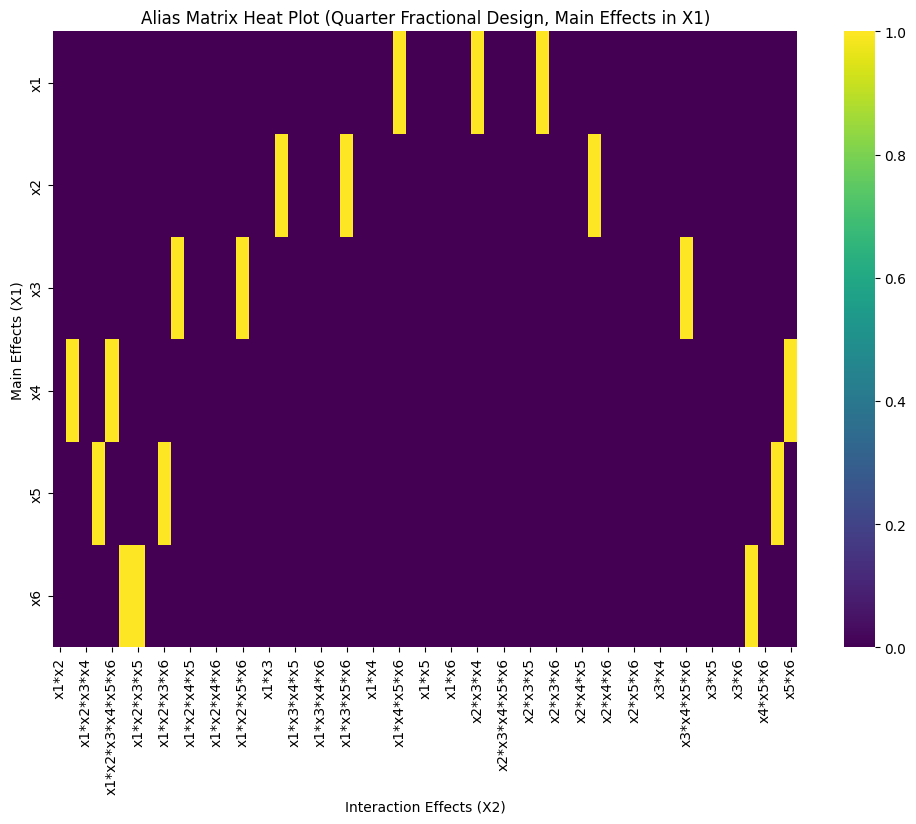

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the alias matrix as a heat plot
plt.figure(figsize=(12, 8)) # Adjust figure size as needed for readability
sns.heatmap(alias_matrix_df, annot=False, cmap='viridis', cbar=True)
plt.title("Alias Matrix Heat Plot (Quarter Fractional Design, Main Effects in X1)")
plt.xlabel("Interaction Effects (X2)")
plt.ylabel("Main Effects (X1)")
plt.show()

# Software for DoE
The [Dexpy package](https://statease.github.io/dexpy/index.html) allows for analysis of aliasing.

In [ ]:
!pip install dexpy

In [ ]:
2**5/2

16.0

In [ ]:
import dexpy.factorial
import dexpy.power
import dexpy

import statsmodels.formula.api as smf

design = dexpy.factorial.build_factorial(4, 8)
power_output = dexpy.power.f_power("1 + X1 + X2 + X3 + X4", design, 2.0, 0.05)

print("Statistical power for the model terms:")
for power_value in power_output:
    print(f"{power_value:.4f}") # Print each value formatted to 4 decimal places

display(design) # Display the design DataFrame as before

Statistical power for the model terms:
0.9502
0.4900
0.4900
0.4900
0.4900


,X1,X2,X3,X4
0,-1,-1,-1,-1
1,-1,-1,1,1
2,-1,1,-1,1
3,-1,1,1,-1
4,1,-1,-1,1
5,1,-1,1,-1
6,1,1,-1,-1
7,1,1,1,1


## Iterate and calculate power

Loop through the number of variables, build the half factorial design for each, define a model (e.g., main effects), calculate the statistical power using `dexpy.power.f_power`, and store the results.


In [ ]:
# Create a list of the number of variables to consider
num_variables_range = list(range(4, 10))

# Define the effect size (delta)
delta = 2.0

# Initialize an empty list to store the calculated power values
power_values = []

# Iterate through each number of variables in the num_variables_range list
for num_vars in num_variables_range:
    # Build a half factorial design for the current number of variables
    # A half factorial design for k variables has 2**(k-1) runs.
    num_runs = 2**(num_vars - 1)
    design = dexpy.factorial.build_factorial(num_vars, num_runs)

    # Construct a model formula string for the main effects
    model_formula = "1" # Intercept
    for i in range(1, num_vars + 1):
        model_formula += f" + X{i}"

    # Calculate the statistical power for the defined model and the generated design
    # Use the delta variable for the effect size and 0.05 for the alpha level.
    power_output = dexpy.power.f_power(model_formula, design, delta, 0.05)

    # Append the calculated power value to the list
    # The f_power function returns a list of power values for each term in the model formula.
    # For main effects model, the first value is for the intercept (which is usually 1.0),
    # and the subsequent values are for the main effects. We are interested in the power
    # for the main effects, so we can take the average or look at individual values.
    # For simplicity in plotting later, let's store the power for the first main effect (X1)
    # You could also store all power values or an average if preferred.
    # Assuming the power for each main effect in a balanced design is the same:
    power_values.append(power_output[1]) # power_output[0] is for the intercept

# After the loop, power_values list will contain the power for each number of variables
print("Calculated power values for the first main effect (X1) for each number of variables:")
print(power_values)

Calculated power values for the first main effect (X1) for each number of variables:
[np.float64(0.49002729550798196), np.float64(0.9488352557576998), np.float64(0.999738919737366), np.float64(0.9999999981594917), np.float64(1.0), np.float64(1.0)]


In [ ]:
# Create a pandas DataFrame from the collected data
power_summary_df = pd.DataFrame({
    'Number of Variables': num_variables_range,
    'Statistical Power': power_values
})

# Display the created DataFrame
print("Summary of Statistical Power for Half Factorial Designs:")
display(power_summary_df)

Summary of Statistical Power for Half Factorial Designs:


,Number of Variables,Statistical Power
0,4,0.490027
1,5,0.948835
2,6,0.999739
3,7,1.000000
4,8,1.000000
5,9,1.000000


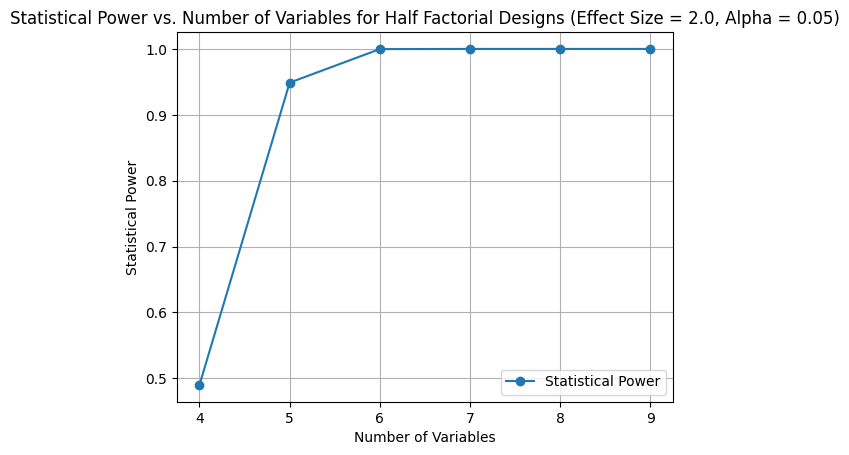

In [ ]:
import matplotlib.pyplot as plt

# Plot the data
power_summary_df.plot(x='Number of Variables', y='Statistical Power', marker='o')

# Add labels and title
plt.xlabel("Number of Variables")
plt.ylabel("Statistical Power")
plt.title("Statistical Power vs. Number of Variables for Half Factorial Designs (Effect Size = 2.0, Alpha = 0.05)")
plt.grid(True)
plt.show()

## How about aliasing effects...

In [ ]:
import dexpy.alias

# Create a dummy response variable for demonstration
design = dexpy.factorial.build_factorial(6, 16)
power_output = dexpy.power.f_power("1 + X1 + X2 + X3 + X4 + X5 + X6 ", design, 2.0, 0.05)
aliases, alias_coefs = dexpy.alias.alias_list("(X1+X2+X3+X4+X5+X6)**2", design)
print(design)
print(aliases)

    X1  X2  X3  X4  X5  X6
0   -1  -1  -1  -1  -1  -1
1   -1  -1  -1   1  -1   1
2   -1  -1   1  -1   1   1
3   -1  -1   1   1   1  -1
4   -1   1  -1  -1   1   1
5   -1   1  -1   1   1  -1
6   -1   1   1  -1  -1  -1
7   -1   1   1   1  -1   1
8    1  -1  -1  -1   1  -1
9    1  -1  -1   1   1   1
10   1  -1   1  -1  -1   1
11   1  -1   1   1  -1  -1
12   1   1  -1  -1  -1   1
13   1   1  -1   1  -1  -1
14   1   1   1  -1   1  -1
15   1   1   1   1   1   1
['X1:X2 = X3:X5', 'X1:X3 = X2:X5', 'X1:X4 = X5:X6', 'X1:X5 = X2:X3 + X4:X6', 'X1:X6 = X4:X5', 'X2:X4 = X3:X6', 'X2:X6 = 0.5*X3:X4', 'X3:X4 = 0.5000000000000002*X2:X6']


hmm, Twe get 0.5X3X4... this coefficient indicates partial aliasing between the effects.

In a fractional factorial design, effects can be:

- Perfectly Aliased: This happens when the columns representing two effects in the design matrix are identical or perfectly opposite (e.g., column A is equal to column B, or column A is equal to -1 times column B). In this case, the aliasing coefficient would be +1 or -1, and you cannot distinguish between the two effects at all based on the experimental data.
- Partially Aliased: This happens when the columns representing two effects are correlated but not perfectly. In this case, the estimated effect of one term is a weighted sum of the true effects of the aliased terms, and the weight is a fractional value between 0 and 1 (or -1 and 0), like 0.5. You can get some information about each effect, but their estimates are still confounded.
- Orthogonal: This happens when the columns representing two effects are uncorrelated. The aliasing coefficient is 0, and the effects are not aliased with each other.

In the case of 'X2:X6 = 0.5*X3:X4', it means that the estimated effect of the X2:X6 interaction is partially aliased with the X3:X4 interaction, with a coefficient of 0.5. Similarly, the estimated effect of X3:X4 is partially aliased with X2:X6 with a coefficient of approximately 0.5.

This partial aliasing arises from the specific structure of the 6-factor, 16-run design used. This is likely a specific type of fractional factorial design (like a Resolution IV or lower) where some two-way interactions are partially aliased with other two-way interactions.

So, the 0.5 means that the estimated effect of X2:X6 is only half as strongly confounded with X3:X4 as it would be if they were perfectly aliased (coefficient of 1). You can still get some information about each effect, but their estimates are not independent.

# How about other designs
https://github.com/danieleongari/awesome-design-of-experiments lists many different DOE packages in python.
[DOEPY](https://doepy.readthedocs.io/en/latest/) and [pydoe](https://pypi.org/project/pyDOE/) have many other experimental designs.  

Install doepy using pip

In [ ]:
!pip install doepy

## Load the modules we need

In [ ]:
from doepy import read_write, build

### Full factorial design
Let’s say you have a design problem with the following table for the parameters range. Imagine this as a generic example of a checmical process in a manufacturing plant. You have 3 levels of Pressure, 3 levels of Temperature, 2 levels of FlowRate, and 2 levels of Time.

In [ ]:
build.full_fact(
{'Pressure':[40,55,70],
'Temperature':[290, 320, 350],
'Flow rate':[0.2,0.4],
'Time':[5,8]}
)

/usr/local/lib/python3.12/dist-packages/doepy/doe_functions.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.iloc[i][j]=r[j][int(df.iloc[i][j])]


,Pressure,Temperature,Flow rate,Time
0,40.0,290.0,0.2,5.0
1,55.0,290.0,0.2,5.0
2,70.0,290.0,0.2,5.0
3,40.0,320.0,0.2,5.0
4,55.0,320.0,0.2,5.0
5,70.0,320.0,0.2,5.0
6,40.0,350.0,0.2,5.0
7,55.0,350.0,0.2,5.0
8,70.0,350.0,0.2,5.0
9,40.0,290.0,0.4,5.0


### Latin Hypercube design
Sometimes, a set of randomized design points within a given range could be attractive for the experimenter to asses the impact of the process variables on the output. Monte Carlo simulations are close example of this approach.

However, a Latin Hypercube design is better choice for experimental design rather than building a complete random matrix as it tries to subdivide the sample space in smaller cells and choose only one element out of each subcell. This way, a more uniform spreading’ of the random sample points can be obtained.

User can choose the density of sample points. For example, if we choose to generate a Latin Hypercube of 12 experiments from the same input files, that could look like,

In [ ]:
lhs_design_df =build.space_filling_lhs(
{'Pressure':[40,55,70],
'Temperature':[290, 320, 350],
'Flow rate':[0.2,0.4],
'Time':[5,11]},
num_samples = 12
)
lhs_design_df

Pressure had more than two levels. Assigning the end point to the high level.
Temperature had more than two levels. Assigning the end point to the high level.


,Pressure,Temperature,Flow rate,Time
0,61.818182,317.272727,0.363636,6.636364
1,64.545455,333.636364,0.381818,7.727273
2,56.363636,339.090909,0.309091,5.000000
3,40.000000,344.545455,0.400000,6.090909
4,53.636364,311.818182,0.218182,5.545455
5,48.181818,295.454545,0.272727,9.363636
6,45.454545,300.909091,0.254545,8.272727
7,50.909091,350.000000,0.290909,10.454545
8,67.272727,306.363636,0.200000,11.000000
9,42.727273,328.181818,0.327273,9.909091


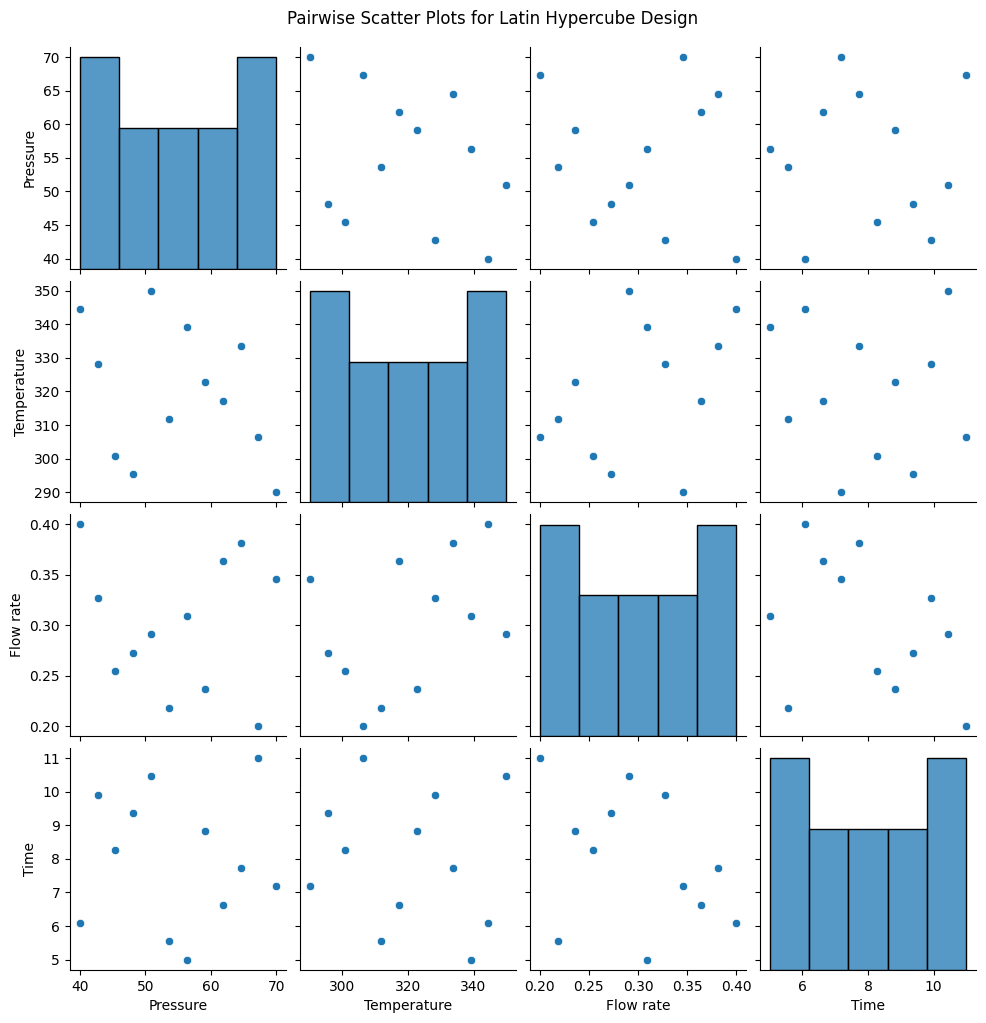

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns



# Create scatter plots for pairs of variables
sns.pairplot(lhs_design_df)
plt.suptitle("Pairwise Scatter Plots for Latin Hypercube Design", y=1.02)
plt.show()

Of course, there is no guarantee that you will get the same matrix if you run this function because this are randomly sampled, but you get the idea!

Other functions to try on Try any one of the following designs,

- Full factorial: build.full_fact()
- 2-level fractional factorial: build.frac_fact_res()
- Plackett-Burman: build.plackett_burman()
- Sukharev grid: build.sukharev()
- Box-Behnken: build.box_behnken()
- Box-Wilson (Central-composite) with center-faced option: build.central_composite() with face='ccf' option
- Box-Wilson (Central-composite) with center-inscribed option: build.central_composite() with face='cci' option
- Box-Wilson (Central-composite) with center-circumscribed option: build.central_composite() with face='ccc' option
- Latin hypercube (simple): build.lhs()
- Latin hypercube (space-filling): build.space_filling_lhs()
- Random k-means cluster: build.random_k_means()
- Maximin reconstruction: build.maximin()
- Halton sequence based: build.halton()
- Uniform random matrix: build.uniform_random()

After performing the experiments, we analyze in the way we done in previous tutorials.